In [2]:
import wrds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

(a)

In [3]:
#loading data
db = wrds.Connection(wrds_username='edvardc')

mkt = db.raw_sql("select date, vwretd from crsp.msi where date>='2000-01-01' and date<='2019-12-31'", date_cols=['date'])
tbills = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='2000-01-01' and mcaldt<='2019-12-31'")

stocksraw = db.raw_sql("select a.date, a.ret, a.prc, a.shrout, a.permno from crsp.msf as a left join crsp.msenames as b on a.permno=b.permno and b.namedt<=a.date and b.nameendt>=a.date where a.date>='2000-01-01' and a.date<='2019-12-31' and b.shrcd in (10, 11) and b.exchcd in (1, 2)", date_cols=['date'])

Loading library list...
Done


In [4]:
#transform T-Bills into simple monthly figures
tbills_m = np.transpose(pd.DataFrame([tbills.mcaldt, np.log(1+tbills.tmytm/100) / 12]))
r0 = np.mean(tbills_m.tmytm)

In [10]:
#leaving stocks with full data only
length = stocksraw.groupby(['permno']).agg(['count'])['date']
stocks = stocksraw[stocksraw['permno'].isin(length[length['count'] == 240].index)]

# stockspivot = stocks.pivot(index='date', columns='permno', values='ret')
print('Number of stocks with 240 values: ', len(np.unique(stocks.permno)))

Number of stocks with 240 values:  639


In [19]:
print('Stocks with at least one NA value: ')
print(stocks.permno[stocks.ret.isna()].values)
#dropping NA
# stocks = stocks[~stocks['permno'].isin(stocks.permno[stocks.ret.isna()].values)]

Stocks with at least one NA value: 
[64899. 84302. 87541.]


In [6]:
#calculating market cap.
stocks['mktcap'] = np.abs(stocks['prc']) * stocks['shrout']

Stocks with at least one NA value were removed from analysis.

In [12]:
#deciles from last date for part b)
last_date = stocks[stocks.date == '2019-12-31']
last_date.loc[:,'deciles_b'] = pd.qcut(last_date.mktcap, 10).cat.codes
stocks = stocks.merge(last_date[['permno', 'deciles_b']], on = 'permno', how = 'left')

#monthly deciles for part c)
deciles_c = np.zeros((len(np.unique(stocks.date))*len(np.unique(stocks.permno)), 1))  
stocks_sorted = stocks.sort_values(by=['date', 'permno'])
i = 0
for date in np.unique(stocks_sorted.date):
    #9 - highest market cap, 0 - lowest
    deciles_c[i:i + len(np.unique(stocks.permno))] = pd.DataFrame(pd.qcut(stocks_sorted[stocks_sorted.date == date].mktcap, 10).cat.codes)
    i = i + len(np.unique(stocks_sorted.permno))
deciles_c = pd.DataFrame(deciles_c, index = stocks_sorted.index, columns = ['deciles_c'])
    
stocks_sorted = stocks_sorted.merge(deciles_c, on = stocks_sorted.index, how = 'left')
stocks_sorted = stocks_sorted.drop(['key_0'], axis=1)

In [13]:
avg_ex_ret = []
pf_m_ret = []
coefs = []
i = 0
for sorting in ['deciles_b', 'deciles_c']:
    #ew monthly returns
    pf_ew_m_ret = pd.DataFrame(stocks_sorted.groupby([sorting, 'date']).agg(["sum"])['ret']['sum'] / stocks_sorted.groupby([sorting, 'date']).agg(["count"])['ret']['count'])
    pf_ew_m_ret['date'], pf_ew_m_ret[sorting] = pf_ew_m_ret.index.get_level_values('date'), pf_ew_m_ret.index.get_level_values(sorting)
    pf_ew_m_ret = pf_ew_m_ret.reset_index(drop=True)
    pf_ew_m_ret.columns = ['ew_ret', 'date', sorting]
    
    #vw monthly returns
    tot_mktcap = pd.DataFrame(stocks_sorted.groupby([sorting, 'date']).agg(["sum"])['mktcap']['sum'])
    tot_mktcap['date'], tot_mktcap[sorting] = tot_mktcap.index.get_level_values('date'), tot_mktcap.index.get_level_values(sorting)
    tot_mktcap = tot_mktcap.reset_index(drop=True)
    tot_mktcap.columns = ['tot_mktcap', 'date', sorting]
    
    #shifting market cap. time series by a month
    tot_mktcap['tot_mktcap'] = tot_mktcap.groupby([sorting])['tot_mktcap'].shift(1)
    stocks_sorted_mktcap = stocks_sorted.merge(tot_mktcap, on = [sorting, 'date'], how = 'left')
    
    #deleting first date of time series from analysis
    stocks_sorted_mktcap = stocks_sorted_mktcap[~(stocks_sorted_mktcap.date == '2001-01-31')]
    
    stocks_sorted_mktcap['mktcap_weight'] = stocks_sorted_mktcap['mktcap'] / stocks_sorted_mktcap['tot_mktcap']
    stocks_sorted_mktcap['vwret'] = stocks_sorted_mktcap['mktcap_weight'] * stocks_sorted_mktcap['ret']
    
    pf_vw_m_ret = pd.DataFrame(stocks_sorted_mktcap.groupby([sorting, 'date']).agg(["sum"])['vwret']['sum'])
    pf_vw_m_ret['date'], pf_vw_m_ret[sorting] = pf_vw_m_ret.index.get_level_values('date'), pf_vw_m_ret.index.get_level_values(sorting)
    pf_vw_m_ret = pf_vw_m_ret.reset_index(drop=True)
    pf_vw_m_ret.columns = ['vw_ret', 'date', sorting]
    
    pf_m_ret.append(pf_ew_m_ret.merge(pf_vw_m_ret, on = [sorting, 'date'], how = 'left'))
    
    
    #average returns, betas and alphas of 10 portfolios
    mkt_ex = pd.DataFrame(mkt.vwretd.values - r0)
    mkt_ex['const'] = 1
        
    ex_ret = {}
    alpha = {}
    beta = {}
    for ret in ['ew_ret', 'vw_ret']:
        ex_ret[ret] = pf_m_ret[i].groupby(sorting).agg(["sum"])[ret]['sum'] / pf_m_ret[i].groupby(sorting).agg(["count"])[ret]['count'] - r0
        for pf in np.unique(pf_m_ret[i][sorting]):
            model = sm.OLS(endog=pf_m_ret[i][pf_m_ret[i][sorting] == pf][ret].values, exog=mkt_ex, missing='drop').fit()
            beta[ret, pf] = model.params[0]
            alpha[ret, pf] = model.params["const"]
            
    alpha = pd.DataFrame(alpha.values(), index = alpha.keys())
    alpha['ret_type'], alpha[sorting] = alpha.index.get_level_values(0), alpha.index.get_level_values(1)
    
    beta = pd.DataFrame(beta.values(), index = beta.keys())
    beta['ret_type'], beta[sorting] = beta.index.get_level_values(0), beta.index.get_level_values(1)
    
    coefs.append(alpha.merge(beta, on = ['ret_type', sorting]))
    coefs[i].columns = ['alpha', 'ret_type', sorting, 'beta']
    
    avg_ex_ret.append(ex_ret)
    
    i = i + 1

In [40]:
table = pd.DataFrame({
                    'Avg. ex. return (%)' : avg_ex_ret[0]['ew_ret'].values * 1200,
                    'Alpha' : coefs[0][coefs[0].ret_type == 'ew_ret']['alpha'].values * 12, 
                    'Beta' : coefs[0][coefs[0].ret_type == 'ew_ret']['beta'].values,
                    'Avg. ex. return (%) ' : avg_ex_ret[0]['vw_ret'].values * 1200,
                    'Alpha ' : coefs[0][coefs[0].ret_type == 'vw_ret']['alpha'].values * 12, 
                    'Beta ' : coefs[0][coefs[0].ret_type == 'vw_ret']['beta'].values,
                      }, index = np.arange(1, 11))
print('\n (b) Annualized statistics of the portfolios. Portfolio 1 - decile with lowest market capitalization stocks, portfolio 10 - with highest market capitalization stocks.')
print('\n        Equally weighted                   Value weighted')
display(np.around(table,3))


 (b) Annualized statistics of the portfolios. Portfolio 1 - decile with lowest market capitalization stocks, portfolio 10 - with highest market capitalization stocks.

        Equally weighted                   Value weighted


,Avg. ex. return (%),Alpha,Beta,Avg. ex. return (%),Alpha,Beta
1,10.741,0.063,1.094,20.809,0.159,1.216
2,12.324,0.072,1.220,17.163,0.122,1.233
3,14.074,0.089,1.228,19.728,0.158,1.046
4,13.794,0.086,1.236,21.658,0.170,1.181
5,13.623,0.097,1.006,16.827,0.134,0.937
6,14.305,0.098,1.117,17.267,0.133,1.052
7,14.542,0.105,1.028,17.653,0.137,1.040
8,12.939,0.095,0.912,16.611,0.131,0.961
9,13.272,0.104,0.818,14.633,0.116,0.860
10,10.733,0.082,0.753,11.583,0.094,0.707


(c)

When looking at the table, we can notice that the relation between average excess return of equal weighted portfolios and the market capitalization is quadratic: as the market cap. increases, firstly, the return increases, then starts to go down as we reach the top market capitalization portfolios. Furthermore, the relation between average excess return of value weighted portfolios and the market capitalization is somewhat between quadratic and a straight line. It can be observed that the average excess return decreases as we move to the portfolios with bigger market capitalization. A graph showing both relations is given below.

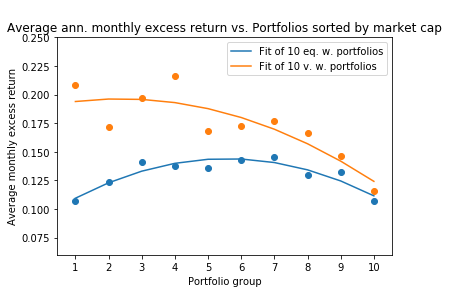

In [22]:
#plot
x = np.arange(1,11)
y = avg_ex_ret[0]['ew_ret'].values * 12
plt.scatter(x, y)
z = avg_ex_ret[0]['vw_ret'].values * 12
plt.scatter(x, z)
plt.ylabel('Average monthly excess return')
plt.xlabel('Portfolio group')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), label = 'Fit of 10 eq. w. portfolios')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, z, 2))(np.unique(x)), label = 'Fit of 10 v. w. portfolios')
plt.legend()
plt.title('\nAverage ann. monthly excess return vs. Portfolios sorted by market cap')
plt.ylim(0.06, 0.25)
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.show()

Can the CAPM explain the behaviour of the stocks? Let's analyse this question with the help of the graph below. For equally weighted portfolios: we notice that the slope of the market excess return line is less steep, than the slope of fit line through the portfolios. It can also be observed that the whole portfolio fit line is shifted up, relative to the CAPM predicted line. This means that returns from these portfolios are higher than expected. Thus CAPM does not predict the returns accurately.

For the value weighted portfolios the situation is a bit different. The slope of the market excess return line is steeper, than the slope of fit line through the portfolios. Additionally, the intercept of the portfolio fit line is much higher than the risk-free rate, making the portfolio fit line almost parallel to the abscissa axis. As a result, the value weighted portfolios seem to have higher than expected returns with smaller beta and lower than expected returns with high beta (if we extended both lines to the right, it is obvious that return for high beta portfolios would be too low).

In [15]:
def abline(slope, intercept, title):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, label=title)

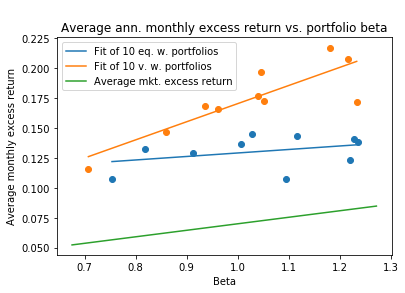

In [16]:
#plot
x = coefs[0][coefs[0].ret_type == 'ew_ret']['beta'].values
y = avg_ex_ret[0]['ew_ret'].values * 12
plt.scatter(x, y)
w = coefs[0][coefs[0].ret_type == 'vw_ret']['beta'].values
z = avg_ex_ret[0]['vw_ret'].values * 12
plt.scatter(w, z)
plt.ylabel('Average monthly excess return')
plt.xlabel('Beta')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label = 'Fit of 10 eq. w. portfolios')
plt.plot(np.unique(w), np.poly1d(np.polyfit(w, z, 1))(np.unique(w)), label = 'Fit of 10 v. w. portfolios')
abline(np.mean(mkt_ex[0])*12, r0 * 12, 'Average mkt. excess return')
plt.legend()
plt.title('\nAverage ann. monthly excess return vs. portfolio beta')
plt.show()

In [41]:
table1 = pd.DataFrame({
                    'Avg. ex. return (%)' : avg_ex_ret[1]['ew_ret'].values * 1200,
                    'Alpha' : coefs[1][coefs[1].ret_type == 'ew_ret']['alpha'].values * 12, 
                    'Beta' : coefs[1][coefs[1].ret_type == 'ew_ret']['beta'].values,
                    'Avg. ex. return (%) ' : avg_ex_ret[1]['vw_ret'].values * 1200,
                    'Alpha ' : coefs[1][coefs[1].ret_type == 'vw_ret']['alpha'].values * 12, 
                    'Beta ' : coefs[1][coefs[1].ret_type == 'vw_ret']['beta'].values,
                      }, index = np.arange(1, 11))
print('\n (d) Annualized statistics of the portfolios. Portfolio 1 - decile with lowest market capitalization stocks, portfolio 10 - with highest market capitalization stocks.')
print('\n        Equally weighted                   Value weighted')
display(np.around(table1,3))


 (d) Annualized statistics of the portfolios. Portfolio 1 - decile with lowest market capitalization stocks, portfolio 10 - with highest market capitalization stocks.

        Equally weighted                   Value weighted


,Avg. ex. return (%),Alpha,Beta,Avg. ex. return (%),Alpha,Beta
1,7.017,0.028,1.057,13.638,0.093,1.125
2,14.016,0.084,1.322,20.097,0.147,1.311
3,14.182,0.092,1.195,19.575,0.150,1.169
4,13.064,0.084,1.148,17.393,0.130,1.136
5,14.349,0.100,1.081,18.124,0.140,1.074
6,15.521,0.114,1.034,18.757,0.149,1.020
7,14.724,0.108,0.997,18.196,0.145,0.991
8,13.190,0.095,0.954,16.239,0.130,0.917
9,12.889,0.100,0.813,15.497,0.128,0.803
10,11.404,0.085,0.815,11.972,0.096,0.742


When looking at the table, we notice again that the relation between average excess return of equal weighted portfolios and the market capitalization is quadratic: as the market cap. increases, firstly, the return increases, then starts to go down as we reach the top market capitalization portfolios. Moreover, the relation between average excess return of value weighted portfolios and the market capitalization is also quadratic. As we look at the fit line of portfolios with bigger market capitalization, we notice that the average excess return decreases and becomes more similar between the equally weighted and value weighted portfolios - similarly as in part b). However, for low beta portfolios the difference between portfolio returns is smaller than in part b). A graph showing both relations is given above.

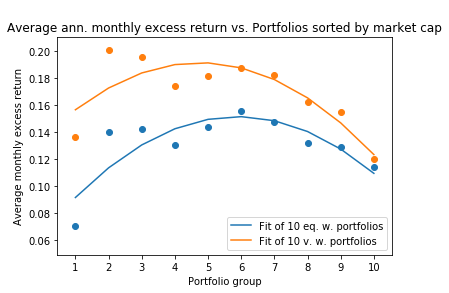

In [21]:
#plot
x = np.arange(1,11)
y = avg_ex_ret[1]['ew_ret'].values * 12
plt.scatter(x, y)
z = avg_ex_ret[1]['vw_ret'].values * 12
plt.scatter(x, z)
plt.ylabel('Average monthly excess return')
plt.xlabel('Portfolio group')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), label = 'Fit of 10 eq. w. portfolios')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, z, 2))(np.unique(x)), label = 'Fit of 10 v. w. portfolios')
plt.legend()
plt.title('\nAverage ann. monthly excess return vs. Portfolios sorted by market cap')
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.show()

Can the CAPM explain the behaviour of the stocks? Let's analyse this question with the help of the graph below. Again we notice that equally weighted and value weighted portfolio fit lines are above the CAPM predicted line. This means that portfolios earn higher than expected returns. The intercept of both portfolio fit lines is much higher than the risk-free rate, resulting in an upward shift of these lines. Obviously, there are other factors, such as market capitalization, that could add to a better explanation of stock returns and improve the fit of the average market excess return line.

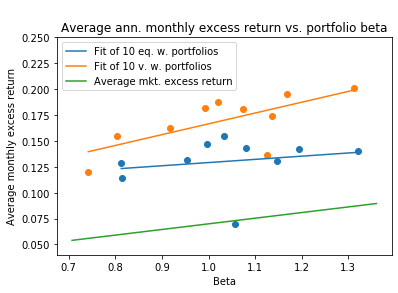

In [24]:
#plot
x = coefs[1][coefs[1].ret_type == 'ew_ret']['beta'].values
y = avg_ex_ret[1]['ew_ret'].values * 12
plt.scatter(x, y)
w = coefs[1][coefs[1].ret_type == 'vw_ret']['beta'].values
z = avg_ex_ret[1]['vw_ret'].values * 12
plt.scatter(w, z)
plt.ylabel('Average monthly excess return')
plt.xlabel('Beta')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label = 'Fit of 10 eq. w. portfolios')
plt.plot(np.unique(w), np.poly1d(np.polyfit(w, z, 1))(np.unique(w)), label = 'Fit of 10 v. w. portfolios')
abline(np.mean(mkt_ex[0])*12, r0 * 12, 'Average mkt. excess return')
plt.legend()
plt.ylim(0.04, 0.25)
plt.title('\nAverage ann. monthly excess return vs. portfolio beta')
plt.show()